# Trends: data exploration


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from glob import glob
from sklearn.model_selection import TimeSeriesSplit
import statsmodels.formula.api as smf
from sklearn.metrics import r2_score
from IPython.display import display, HTML, Markdown
from vol4life.vol4life.plot import plot_acf, plot_ccf
from vol4life.vol4life.stats import autocorrelation_f
from word_list.basic import politics1, politics2
from word_list.basic import business


## Create trends df from daily information

In [2]:
trends_path = os.path.join('data','daily_trend',"*.csv")
daily_dfs_path =  glob(trends_path)
daily_dfs_path.sort()
daily_dfs = [pd.read_csv(path) for path in daily_dfs_path]
daily_dfs_names = [i.split("/")[2] for i in daily_dfs_path]
daily_dfs_names = [i.split(".")[0] for i in daily_dfs_names]

trends_df = []
for name, df in zip(daily_dfs_names, daily_dfs):
    df.index = pd.to_datetime(df.date)
    ts = df[name]
    new_name = name.replace(" ", "_")
    ts.name = new_name
    trends_df.append(ts)

final_date = "2020-07-25"
trends_df = pd.concat(trends_df,1)
trends_df = trends_df[:final_date]
trends_df = trends_df.fillna(0.0)
word_features = list(trends_df.columns)
word_features.sort()
trends_df = trends_df[word_features]
trends_df_train = trends_df[:"2010"]
trends_df_test = trends_df["2010":]
display(Markdown("### Google trends data"))
display(HTML(trends_df_train.head(5).to_html()))
display(Markdown("#### data shape = {}".format(trends_df_train.shape))) 

### Google trends data

,BUY_AND_HOLD,DOW_JONES,act,arts,bank,banking,blacklist,bonds,bubble,business,buy,cancer,car,carolina,case,cash,ceo,chance,college,color,committee,community,companies,conflict,consume,consumption,conty,corporation,council,county,court,crash,credit,crisis,culture,debt,default,democratic,derivatives,development,district,dividend,dow_jones,earnings,earths,economic,economics,economy,elected,election,elections,energy,environment,fed,federal,finance,financial,fine,firm,fond,food,forex,founded,freedom,fun,gain,gains,garden,georgia,global,gold,government,governor,greed,growth,happy,headlines,health,hedge,holiday,home,house,housing,illinois,inc,industry,inflation,invest,investment,judge,justice,kentucky,kitchen,labor,law,legal,leverage,lifestyle,loss,ltd,management,market,marketing,markets,marriage,massachusetts,media,members,metals,million,minister,ministry,missouri,money,movement,movie,nasdaq,notability,nyse,office,ohio,oil,opportunity,ore,party,pennsylvania,police,political,politics,portfolio,present,president,products,profit,project,rare,religion,representatives,republican,restaurant,return,returns,revenue,rich,rights,ring,risk,seats,secretary,security,sell,selling,senate,served,service,services,short,social,society,stats,stock,stocks,success,technology,tennessee,texas,tourism,trader,train,transaction,travel,unemployment,union,vermont,vermount,virginia,voter,voters,votes,war,washington,water,william,winsconsin,wisconsin,world,york
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2004-01-01,0.0,1.0,14.0,25.0,52.0,4.0,1.0,9.0,5.0,46.0,86.0,18.0,77.0,55.0,31.0,10.0,0.0,3.0,63.0,27.0,4.0,49.0,21.0,3.0,0.0,2.0,0.0,14.0,9.0,52.0,20.0,11.0,52.0,3.0,6.0,5.0,5.0,5.0,1.0,10.0,22.0,1.0,1.0,1.0,1.0,4.0,7.0,4.0,0.0,5.0,1.0,13.0,4.0,4.0,33.0,6.0,16.0,13.0,1.0,0.0,70.0,1.0,1.0,11.0,22.0,6.0,0.0,32.0,43.0,11.0,27.0,17.0,2.0,0.0,8.0,25.0,0.0,47.0,1.0,34.0,98.0,85.0,12.0,37.0,28.0,4.0,1.0,1.0,7.0,4.0,6.0,16.0,27.0,6.0,35.0,14.0,0.0,3.0,11.0,4.0,25.0,26.0,9.0,3.0,9.0,27.0,45.0,7.0,1.0,6.0,0.0,3.0,26.0,29.0,2.0,100.0,1.0,0.0,1.0,54.0,58.0,28.0,2.0,1.0,35.0,28.0,26.0,6.0,3.0,6.0,3.0,8.0,26.0,3.0,25.0,3.0,7.0,2.0,4.0,57.0,30.0,4.0,3.0,7.0,7.0,37.0,5.0,6.0,3.0,31.0,7.0,5.0,1.0,1.0,76.0,32.0,18.0,19.0,31.0,8.0,30.0,8.0,3.0,20.0,20.0,66.0,11.0,16.0,23.0,1.0,63.0,7.0,44.0,24.0,0.0,53.0,1.0,1.0,1.0,36.0,60.0,53.0,28.0,0.0,36.0,80.0,80.0
2004-01-02,0.0,2.0,17.0,25.0,90.0,3.0,2.0,5.0,3.0,66.0,76.0,19.0,77.0,49.0,26.0,9.0,1.0,2.0,81.0,25.0,3.0,63.0,18.0,4.0,0.0,2.0,0.0,20.0,11.0,82.0,33.0,11.0,66.0,3.0,8.0,5.0,6.0,5.0,1.0,17.0,32.0,1.0,3.0,1.0,1.0,5.0,4.0,3.0,0.0,3.0,2.0,17.0,4.0,4.0,47.0,11.0,31.0,11.0,5.0,1.0,52.0,1.0,1.0,5.0,15.0,4.0,2.0,29.0,48.0,16.0,29.0,26.0,3.0,1.0,7.0,18.0,1.0,71.0,2.0,28.0,99.0,95.0,14.0,53.0,35.0,10.0,2.0,1.0,10.0,3.0,6.0,15.0,21.0,9.0,52.0,14.0,1.0,2.0,12.0,7.0,36.0,27.0,13.0,3.0,14.0,27.0,41.0,6.0,2.0,4.0,2.0,3.0,24.0,31.0,4.0,95.0,3.0,0.0,2.0,69.0,63.0,26.0,2.0,1.0,33.0,32.0,30.0,10.0,3.0,2.0,3.0,11.0,36.0,3.0,28.0,5.0,5.0,1.0,3.0,44.0,25.0,2.0,8.0,8.0,10.0,30.0,6.0,6.0,10.0,43.0,9.0,5.0,3.0,1.0,93.0,59.0,14.0,24.0,33.0,4.0,35.0,10.0,4.0,26.0,18.0,77.0,10.0,11.0,21.0,1.0,59.0,9.0,54.0,16.0,0.0,61.0,2.0,1.0,1.0,41.0,80.0,55.0,32.0,1.0,36.0,94.0,91.0
2004-01-03,0.0,1.0,16.0,22.0,67.0,5.0,1.0,5.0,6.0,51.0,89.0,21.0,89.0,40.0,27.0,9.0,3.0,3.0,70.0,35.0,3.0,49.0,16.0,3.0,0.0,2.0,0.0,13.0,9.0,69.0,23.0,13.0,60.0,5.0,6.0,2.0,6.0,5.0,1.0,16.0,26.0,2.0,2.0,1.0,0.0,2.0,3.0,5.0,1.0,3.0,1.0,12.0,4.0,3.0,34.0,7.0,14.0,14.0,3.0,1.0,51.0,1.0,1.0,9.0,17.0,8.0,1.0,29.0,41.0,14.0,27.0,19.0,2.0,0.0,6.0,13.0,1.0,53.0,1.0,26.0,93.0,95.0,9.0,44.0,23.0,10.0,1.0,1.0,7.0,3.0,7.0,15.0,26.0,6.0,43.0,13.0,0.0,1.0,13.0,8.0,27.0,32.0,8.0,3.0,11.0,27.0,40.0,8.0,1.0,3.0,2.0,5.0,23.0,28.0,6.0,97.0,2.0,0.0,1.0,62.0,65.0,28.0,2.0,1.0,36.0,27.0,26.0,7.0,2.0,2.0,1.0,10.0,31.0,3.0,27.0,4.0,8.0,2.0,4.0,50.0,26.0,2.0,7.0,9.0,8.0,

#### data shape = (2557, 187)

### Word Signal

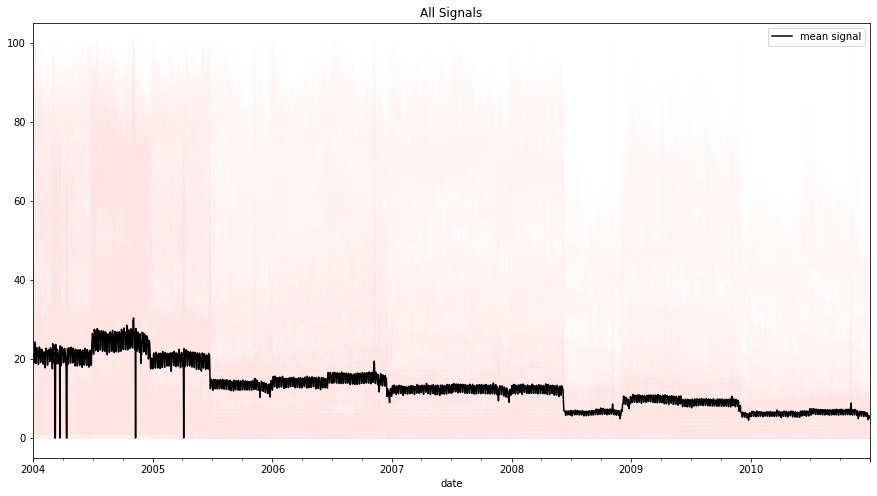

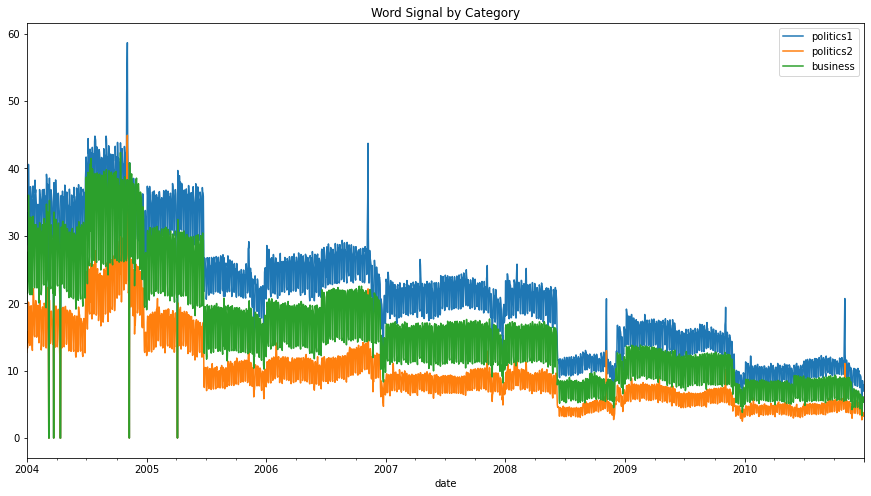

In [3]:
trends_df_p = trends_df_train.copy()
trends_df_p.columns = [""]* trends_df_p.shape[1]

politics1_ts = trends_df_train[politics1].mean(1)
politics1_ts.name = "politics1"
politics2_ts = trends_df_train[politics2].mean(1)
politics2_ts.name = "politics2"
business_ts = trends_df_train[business].mean(1)
business_ts.name = "business"

display(Markdown("### Word Signal"))
fig, ax = plt.subplots(figsize=(15,8))
trends_df_p.plot(ax=ax,legend=False,alpha= 0.05,  color="mistyrose");
trends_df_train.mean(1).plot(ax=ax,legend=False, color="k", label="mean signal");
ax.set_title("All Signals");
ax.legend(loc="best");


fig, ax = plt.subplots(figsize=(15,8))
politics1_ts.plot(ax=ax);
politics2_ts.plot(ax=ax);
business_ts.plot(ax=ax);
ax.set_title("Word Signal by Category");
ax.legend(loc="best");

### Google Trends Correlation

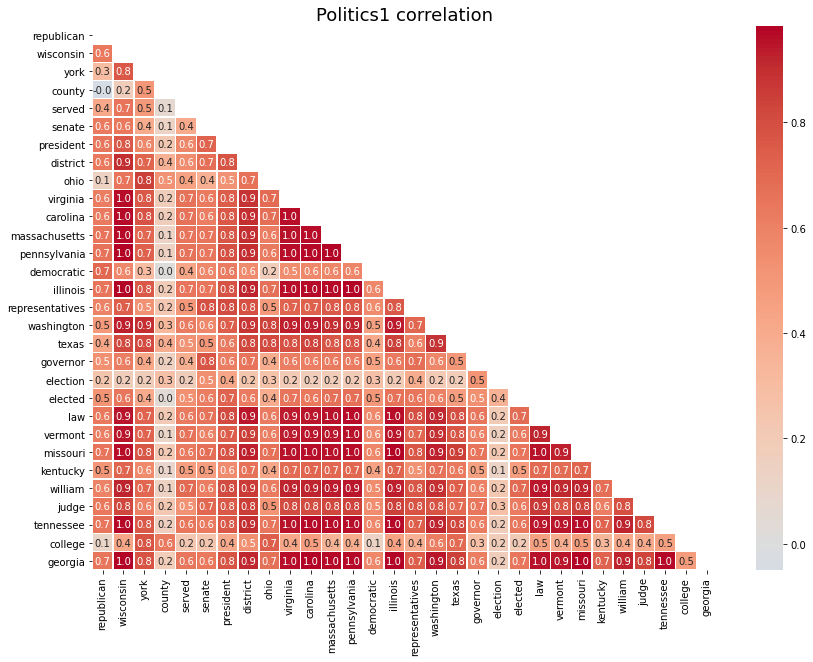

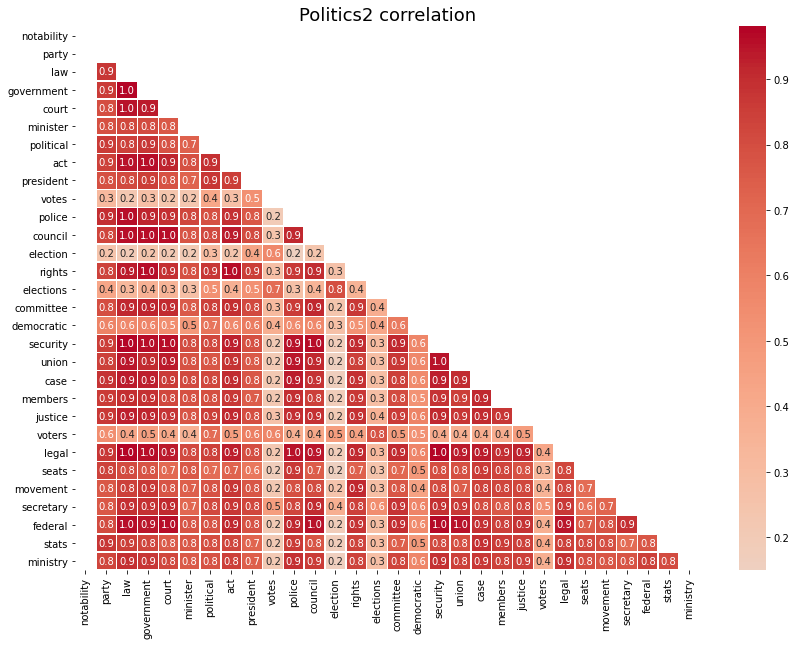

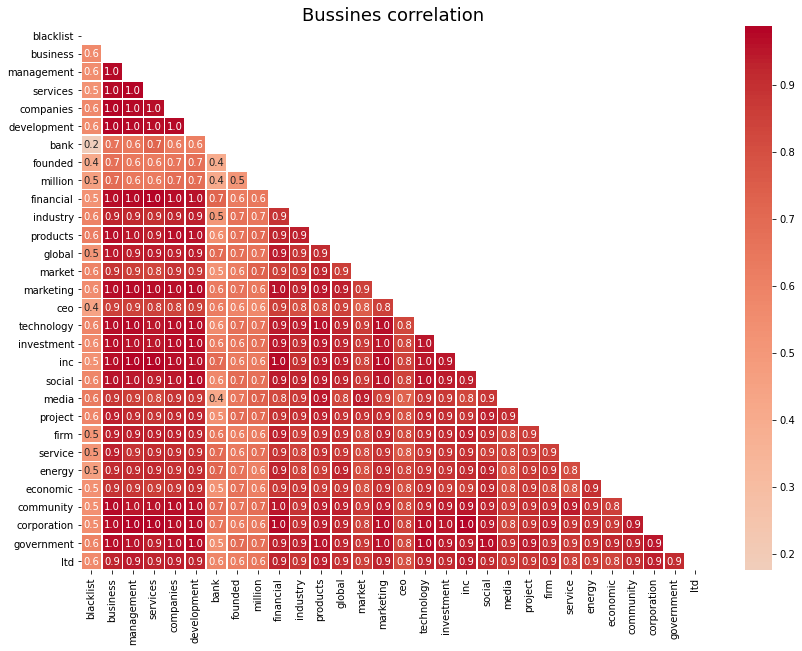

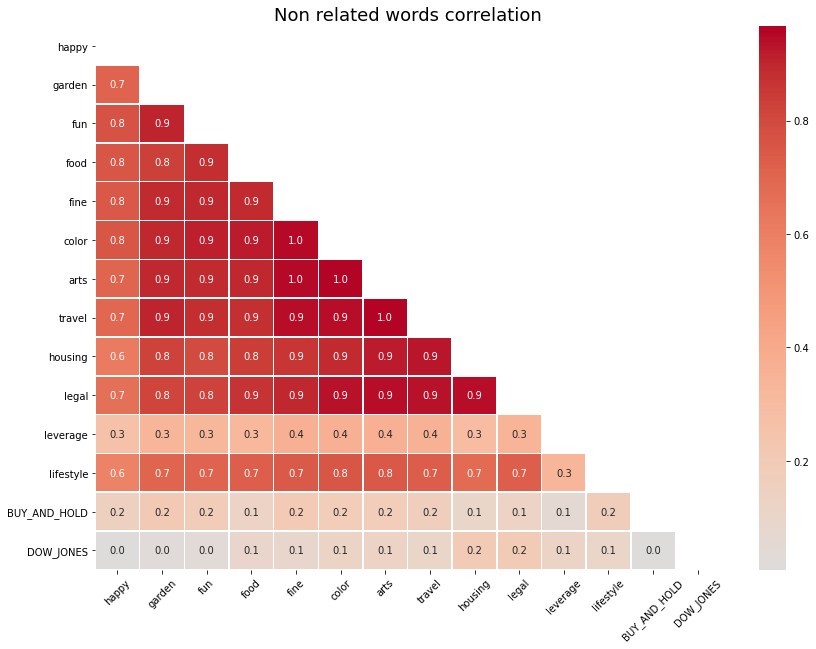

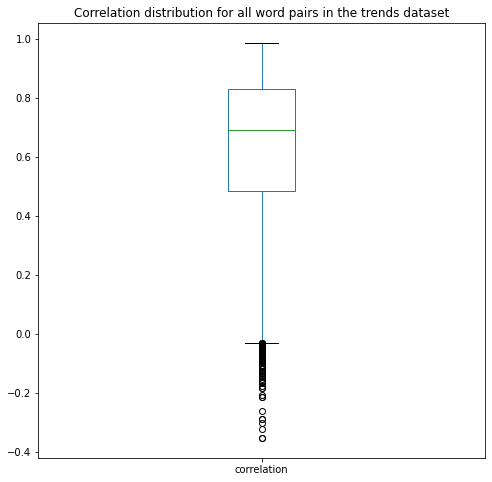

In [9]:
corr = trends_df_train[politics1].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

fig, ax = plt.subplots(figsize=(14,10))
ax.set_title("Politics1 correlation", fontsize=18)
sns.heatmap(corr, mask=mask, cmap="coolwarm", center=0, linewidths=0.5, annot=True, fmt=".1f", ax=ax);
plt.xticks(rotation=90);


corr = trends_df_train[politics2].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

fig, ax = plt.subplots(figsize=(14,10))
ax.set_title("Politics2 correlation", fontsize=18)
sns.heatmap(corr, mask=mask, cmap="coolwarm", center=0, linewidths=0.5, annot=True, fmt=".1f", ax=ax);
plt.xticks(rotation=90);


corr = trends_df_train[business].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

fig, ax = plt.subplots(figsize=(14,10))
ax.set_title("Bussines correlation", fontsize=18)
sns.heatmap(corr, mask=mask, cmap="coolwarm", center=0, linewidths=0.5, annot=True, fmt=".1f", ax=ax);
plt.xticks(rotation=90);

non_related_words = ["happy", "garden", "fun",
                     "food", "fine", "color",
                     "arts", "travel", "housing",
                     "legal", "leverage", "lifestyle",
                     "BUY_AND_HOLD", "DOW_JONES"]

corr = trends_df_train[non_related_words].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

fig, ax = plt.subplots(figsize=(14,10))
ax.set_title("Non related words correlation", fontsize=18)
sns.heatmap(corr, mask=mask, cmap="coolwarm", center=0, linewidths=0.5, annot=True, fmt=".1f", ax=ax);
plt.xticks(rotation=45);

corr = trends_df_train.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
corr_df = pd.DataFrame(corr.mask(cond=mask).values.flatten()).dropna()
corr_df.columns = ["correlation"]
fig, ax = plt.subplots(figsize=(8,8))
corr_df.boxplot(ax=ax, grid=False);
ax.set_title(r"Correlation distribution for all word pairs in the trends dataset");

## Applying PCA

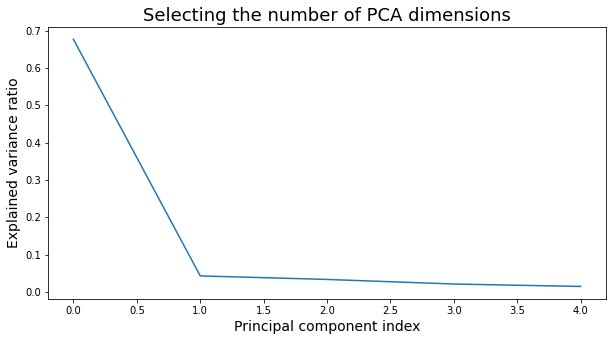

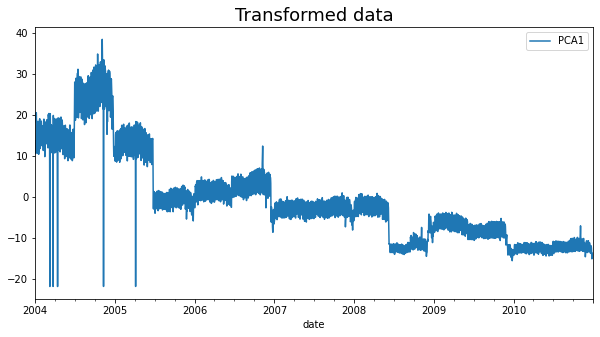

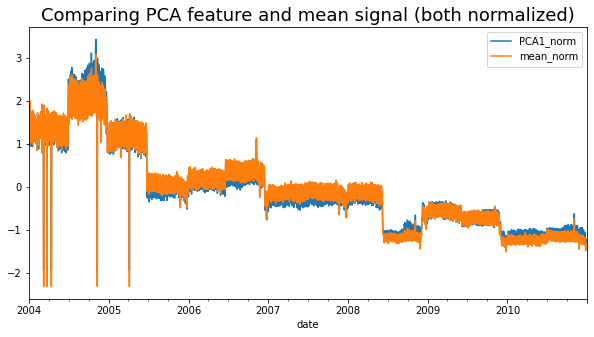

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()
pca = PCA()
trends_std = scaler.fit_transform(trends_df_train)
pca =  pca.fit(trends_std)

fig, ax = plt.subplots(figsize=(10,5))
ax.plot(pca.explained_variance_ratio_[:5])
ax.set_xlabel('Principal component index', fontsize=14)
ax.set_ylabel('Explained variance ratio', fontsize=14)
ax.set_title("Selecting the number of PCA dimensions", fontsize=18)

trends_df_train_t = pd.DataFrame(pca.transform(trends_std)[:,:1],columns=["PCA1"], index=trends_df_train.index)
fig, ax = plt.subplots(figsize=(10,5))
trends_df_train_t.plot(ax=ax);
ax.set_title("Transformed data", fontsize=18);

mean_norm = scaler.fit_transform(trends_df_train.mean(1).to_frame()).flatten()
pca_norm = scaler.fit_transform(trends_df_train_t).flatten()
trends_resume = pd.DataFrame(np.stack([pca_norm,mean_norm],1),columns=["PCA1_norm", "mean_norm"], index=trends_df_train.index)

fig, ax = plt.subplots(figsize=(10,5))
trends_resume.plot(ax=ax);
ax.set_title("Comparing PCA feature and mean signal (both normalized)", fontsize=18);

In [6]:
assert False

AssertionError: 

## Market data returns

In [ ]:
asset = "es1"
market_path = os.path.join('data','market',"{}.txt".format(asset))
df_market = pd.read_csv(market_path, sep='\t')
close_price_column = 'PX_LAST'
date_column='date'
df_market.loc[:, date_column] = pd.to_datetime(df_market[date_column])
df_market = df_market.set_index(date_column)
close = df_market[[close_price_column]].dropna()
close = close.pct_change().dropna()
return_column = "{}_returns".format(asset)
close.columns = [return_column]
close.head(5)

## Merging market data and trends data

In [ ]:
merged_df = pd.merge_asof(trends_df, close, left_index=True, right_index=True)
merged_df = merged_df[[return_column] + word_features]
display(Markdown("### Merged data"))
display(HTML(merged_df.head(5).to_html()))
display(Markdown("#### data shape = {}".format(merged_df.shape)))

### Exploring only one part of the data

In [ ]:
small_df = merged_df[:"2010"].copy()
small_df.head(5)

### Autocorrelation

In [ ]:
returns = small_df.es1_returns
trend = small_df.banking

plot_acf(returns, lag_range=41, out_path=None, acf_function=autocorrelation_f)

plot_acf(trend, lag_range=41, out_path=None, acf_function=autocorrelation_f)

In [ ]:
auto_correlation = []
lags = 30

for c in word_features:
    trend = small_df[c]
    auto_correlation.append(np.mean(autocorrelation_f(trend,lags)[1:]))
auto_correlation = pd.Series(auto_correlation, index=word_features).to_frame()

fig, ax = plt.subplots(figsize=(8,5))
auto_correlation.boxplot(ax=ax, grid=False);
ax.set_title("Mean auto-correlation distribution for trends time series");


In [ ]:
corr = small_df[word_features].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

fig, ax = plt.subplots(figsize=(14,10))
ax.set_title("All words correlation", fontsize=18)
sns.heatmap(corr, mask=mask, cmap="coolwarm", center=0, linewidths=0.5, annot=False, fmt=".2f", ax=ax, cbar=True);
plt.xticks(rotation=90);

## Evaluation Draft

**We use the Time series cross validation from sklearn to observe the distribution
of the statistics related to a simple linear regresion. The model is based only in one
trend word. It tries to predict the next day return of the selected asset**

In [ ]:
# Using only a part of the data

small_df = merged_df[:"2010"].copy()
small_df.head(5)

In [ ]:
# shifting returns. We use the word trend on day t
# to predict returs on the day t+1

small_df.loc[:, "es1_returns"] = small_df.es1_returns.shift(-1)
small_df = small_df.dropna()
small_df.head(5)

### This functions uses the `TimeSeriesSplit` from sklearn to obtain different statistics based on a simple linear model

In [ ]:
def get_simple_ols_stats(df,return_column, select_word, n_splits):

    tscv = TimeSeriesSplit(n_splits=n_splits)
    is_scores = []
    betas = []
    t_stats = []
    p_values = []
    oos_scores = []
    
    for train_index, test_index in tscv.split(df):
        df_train = df.iloc[train_index]
        df_test = df.iloc[test_index]
        formula = "{} ~ {}".format(return_column, select_word)
        lr = smf.ols(formula=formula, data=df_train).fit()
        is_scores.append(lr.rsquared)
        betas.append(lr.params[1])
        t_stats.append(lr.tvalues[1])
        p_values.append(lr.pvalues[1])
        y_pred = lr.predict(df_test).values
        y_true = df_test[return_column]
        oos_r2 = r2_score(y_true, y_pred)
        oos_scores.append(oos_r2)
    
    dict_ = {"IS_rsquared":is_scores,
             "beta":betas,
             "t-statistic":t_stats,
             "p_value":p_values,
             "OOS_rsquared":oos_scores}
        
    return  pd.DataFrame(dict_)



## Experiment Results using some random words 

In [ ]:
n_splits = 10
example =  word_features[4:20]
stats = []
p_values = []
oos_scores = []
is_scores = []

## Getting the results for each word
for word in example: 
    stat = get_simple_ols_stats(df=small_df,
                                return_column=return_column,
                                select_word=word,
                                n_splits=n_splits)
    stats.append(stat)

## Combining results
for word, stat in zip(example, stats):
    ps = stat["p_value"]
    ps.name = word
    p_values.append(ps)
    is_score = stat["IS_rsquared"]
    is_score.name = word
    is_scores.append(is_score)
    os_score = stat["OOS_rsquared"]
    os_score.name = word
    oos_scores.append(os_score)

    
## Plotting
display(Markdown("### Simple Linear Model Results"))
display(Markdown(""))

p_values = pd.concat(p_values, 1)
fig, ax = plt.subplots(figsize=(8,5))
p_values.boxplot(ax=ax, grid=False);
ax.set_xticklabels(example, rotation=45);
ax.set_title("P-value distribution for the coeficients of the explanatory variable");

is_scores = pd.concat(is_scores, 1)
fig, ax = plt.subplots(figsize=(8,5))
is_scores.boxplot(ax=ax, grid=False);
ax.set_xticklabels(example, rotation=45);
ax.set_title(r"In-sample $R^2$ distribution for each simple linear model");


oos_scores = pd.concat(oos_scores, 1)
fig, ax = plt.subplots(figsize=(8,5))
oos_scores.boxplot(ax=ax, grid=False);
ax.set_xticklabels(example, rotation=45);
ax.set_title(r"Out-of-sample $R^2$ distribution for each simple linear model");


In [ ]:
score_table  = oos_scores.mean(0).sort_values(ascending=False).to_frame().transpose()
score_table.index = [r"$R^2$"]

display(Markdown("### Out-of-sample mean $R^2$ for each model"))
display(HTML(score_table.to_html()))